# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math
import re
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import sklearn.metrics as metrics
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm



In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t',dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


<font color=blue> Existe la columna ds_part, la cual nos ayudará con el proceso.</font>

In [6]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

<font color=blue> Existen valores nulos </font>

In [8]:
df_reviews[df_reviews['average_rating'].isna()==True]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


<font color=blue> Se nota en este caso de datos nulos, lo que nos interesa son las reseñas y "pos" por lo tanto solo rellenamos</font>

In [9]:
df_reviews.fillna(0,inplace=True)

In [10]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47331 non-null  float64
 10  votes            47331 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

<font color=blue> ya no hay datos nulos </font>

## EDA

ANALISIS EXPLORATORIO DE DATOS , Veamos el número de películas y reseñas a lo largo de los años.

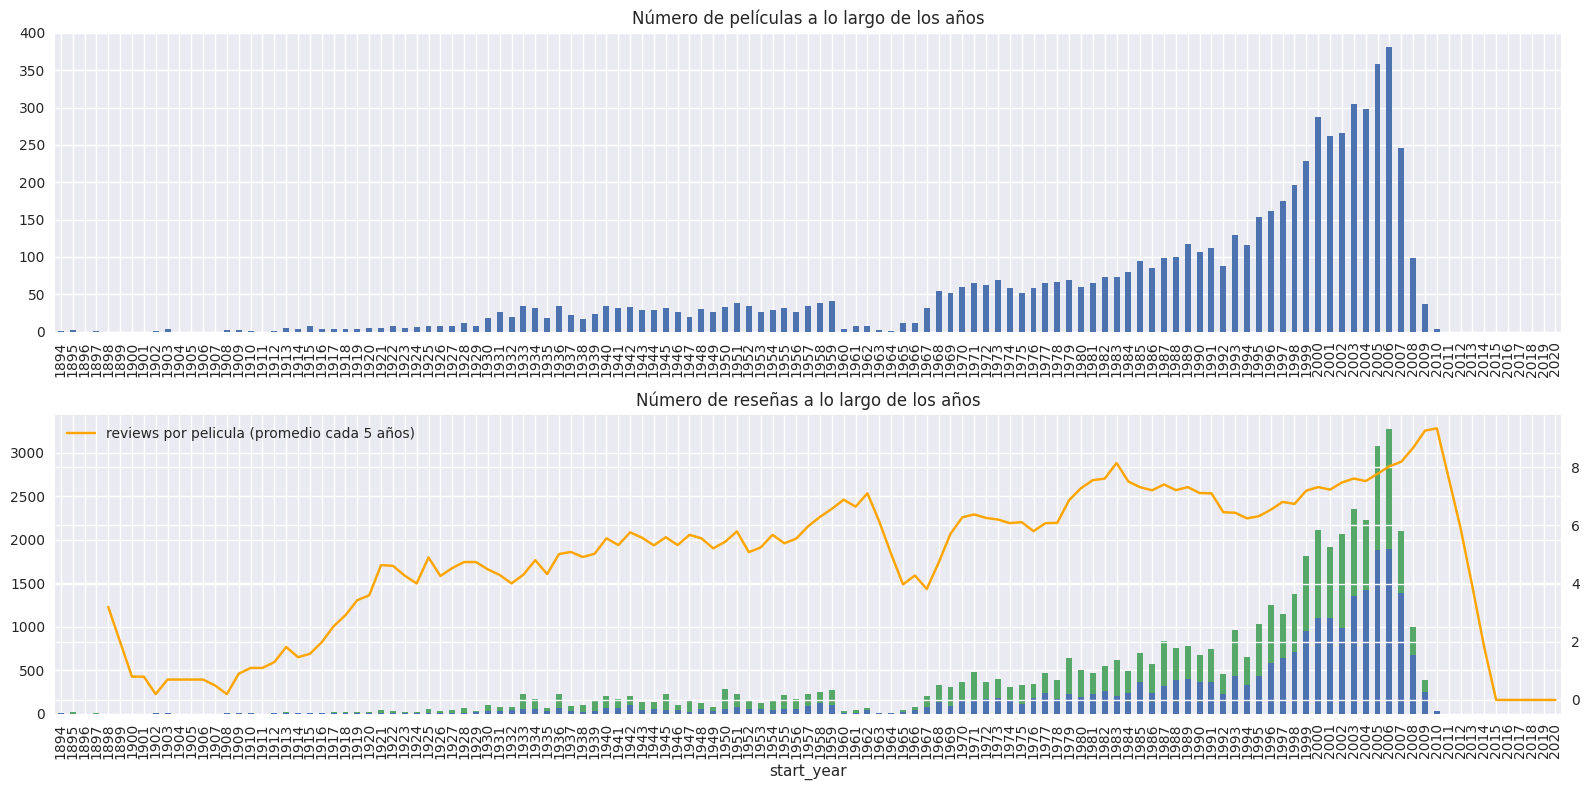

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews por pelicula (promedio cada 5 años)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

<font color=blue>Se puede notar en las graficas que la cantidad de reseñas aumentan desde los años 70's, alcanzando su maximo punto en el año 2006, y cayendo bruscamente en años posteriores, el promedio en la grafica de linea nos muestra un promedio de 2000 a 2500 reviews por cada  años. </font>

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

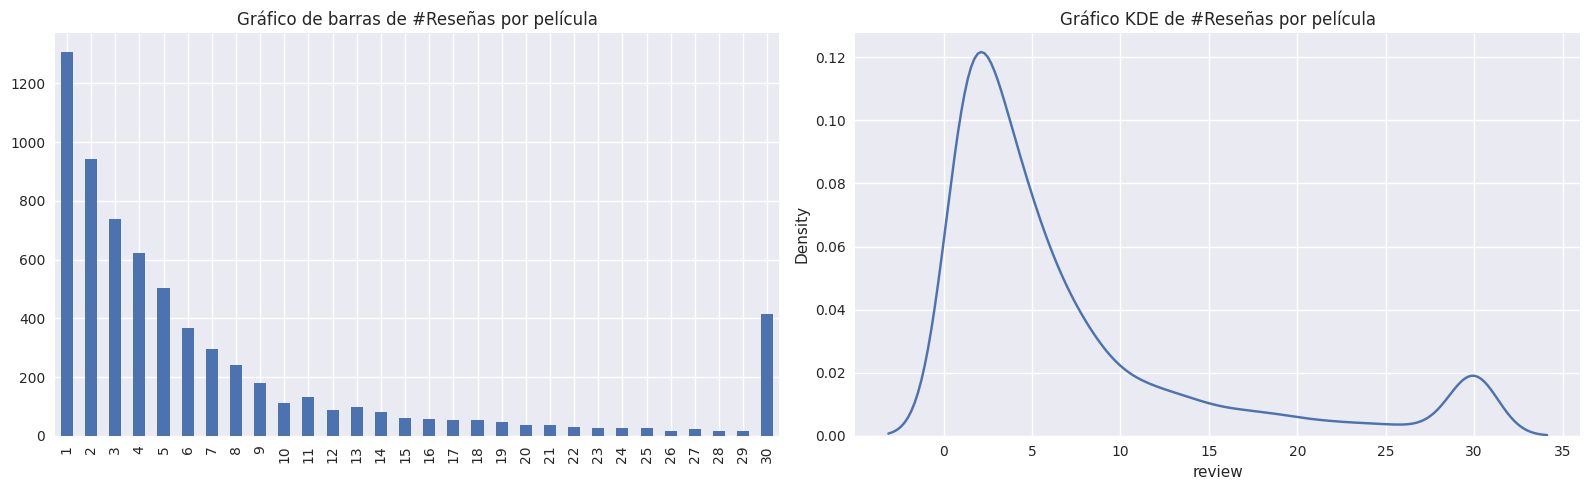

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [13]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

<font color=blue> POS es el objetivo el cual existen 23715 negativos (0) y 23616 positivos(1) </font>

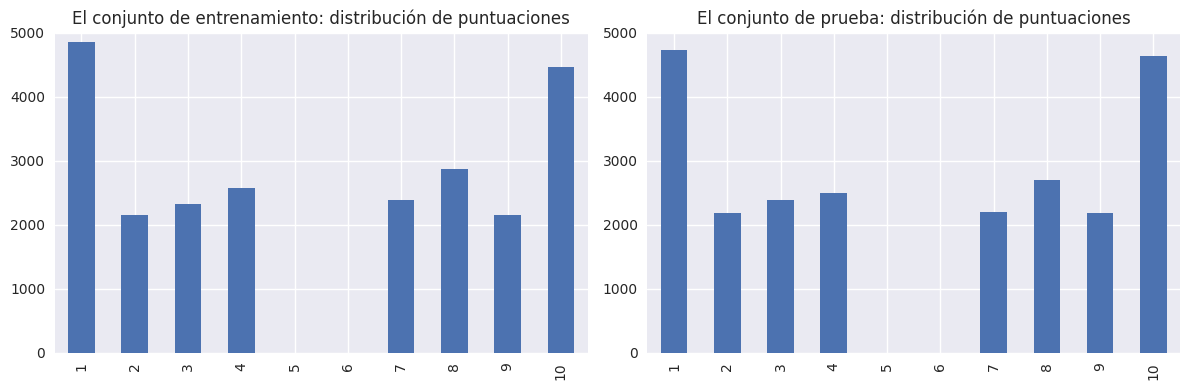

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

<font color=blue>el conjunto de entrenamiento y el conjunto de prueba son muy similares en su distribución </font>

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


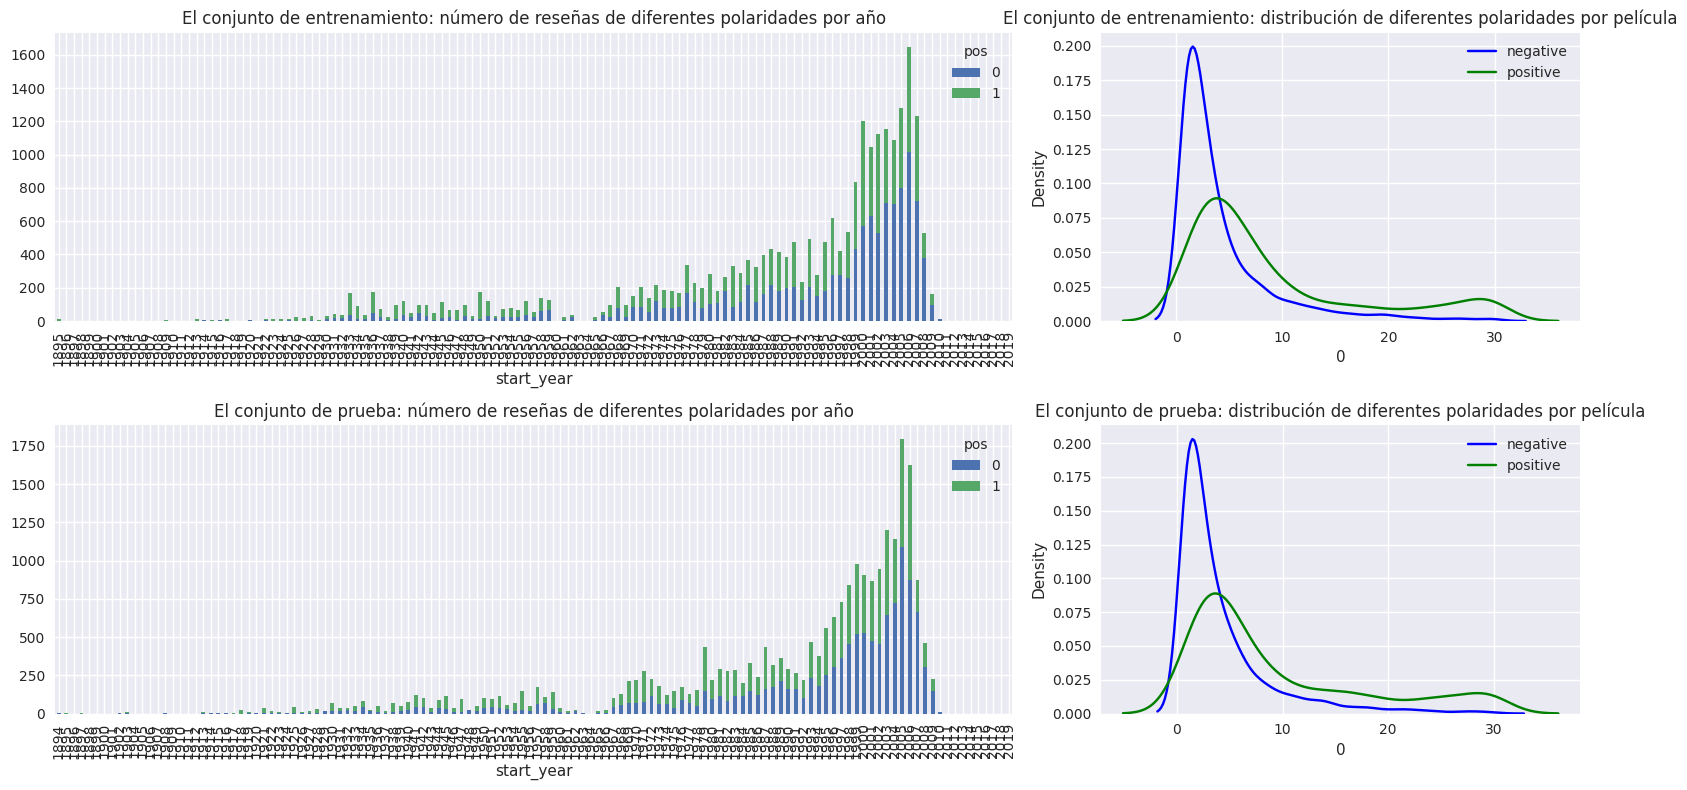

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [16]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return df_eval_stats['test']

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [17]:
def clear_text(text):
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, " ", text)
    text=text.lower()
    text = text.split()
    text = " ".join(text)
    return text

In [18]:
df_reviews['review_norm'] =  df_reviews['review'].apply(clear_text)# <escribe tu código aquí>
print(df_reviews['review'].head())
print()
print(df_reviews['review_norm'].head())

0    The pakage implies that Warren Beatty and Gold...
1    How the hell did they get this made?! Presenti...
2    There is no real story the film seems more lik...
3    Um .... a serious film about troubled teens in...
4    I'm totally agree with GarryJohal from Singapo...
Name: review, dtype: object

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i'm totally agree with garryjohal from singapo...
Name: review_norm, dtype: object


<font color=blue> Las reseñas se normalizan </font>

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.
Por lo tanto se separan por objetivos y por caracteristiacas cada grupo de entrenamiento y de prueba 

In [19]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

test_features=df_reviews_test['review_norm']
train_features=df_reviews_train['review_norm']
print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 1 - Constante

In [20]:
from sklearn.dummy import DummyClassifier

In [21]:
model_1 = DummyClassifier(strategy='uniform')
model_1.fit(df_reviews_train, train_target)

DummyClassifier(strategy='uniform')

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


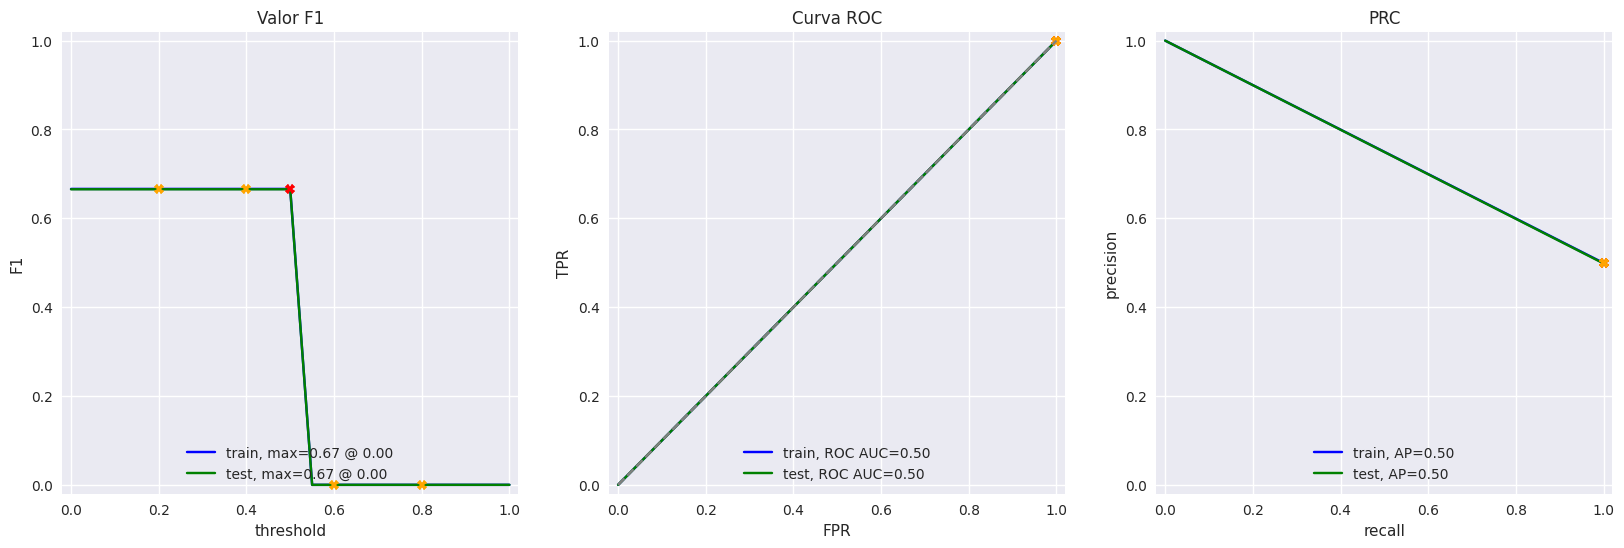

In [22]:
acc_m1, f1_m1, aps_m1, roc_m1=evaluate_model(model_1, df_reviews_train, train_target, df_reviews_test, test_target)

<font color=blue> El modelo constante no predice de manera optima ya que el valor de precision es de .5 </font>

### Modelo 2 - NLTK, TF-IDF y LR

TF-IDF

In [23]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [24]:
def text_nltk(text):
    #stopwords
    words = nltk.word_tokenize(text)
    stop_words = set(nltk_stopwords.words('english'))# palabras en inglés
    filtered_words = [word for word in words if word.lower() not in stop_words]
    #lemmatizer
    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    return ' '.join(lemmatized_words)

In [25]:
def v_tfidf(features_train, features_test):
    vectorizer = TfidfVectorizer()
    features_train_tf_idf = vectorizer.fit_transform(features_train)
    features_test_tf_idf = vectorizer.transform(features_test)
    return features_train_tf_idf, features_test_tf_idf, vectorizer

In [26]:
def lr_model(features_train, target_train):
    model_2 = LogisticRegression()
    model_2.fit(features_train, target_train)
    return model_2

In [27]:
features_train_pre_2 = df_reviews_train['review_norm'].apply(text_nltk)
features_test_pre_2 = df_reviews_test['review_norm'].apply(text_nltk)
train_features_tf_idf_2, test_features_tf_idf_2, tfidf_vectorizer_2 = v_tfidf(features_train_pre_2,features_test_pre_2)
model_2 = lr_model(train_features_tf_idf_2, train_target)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


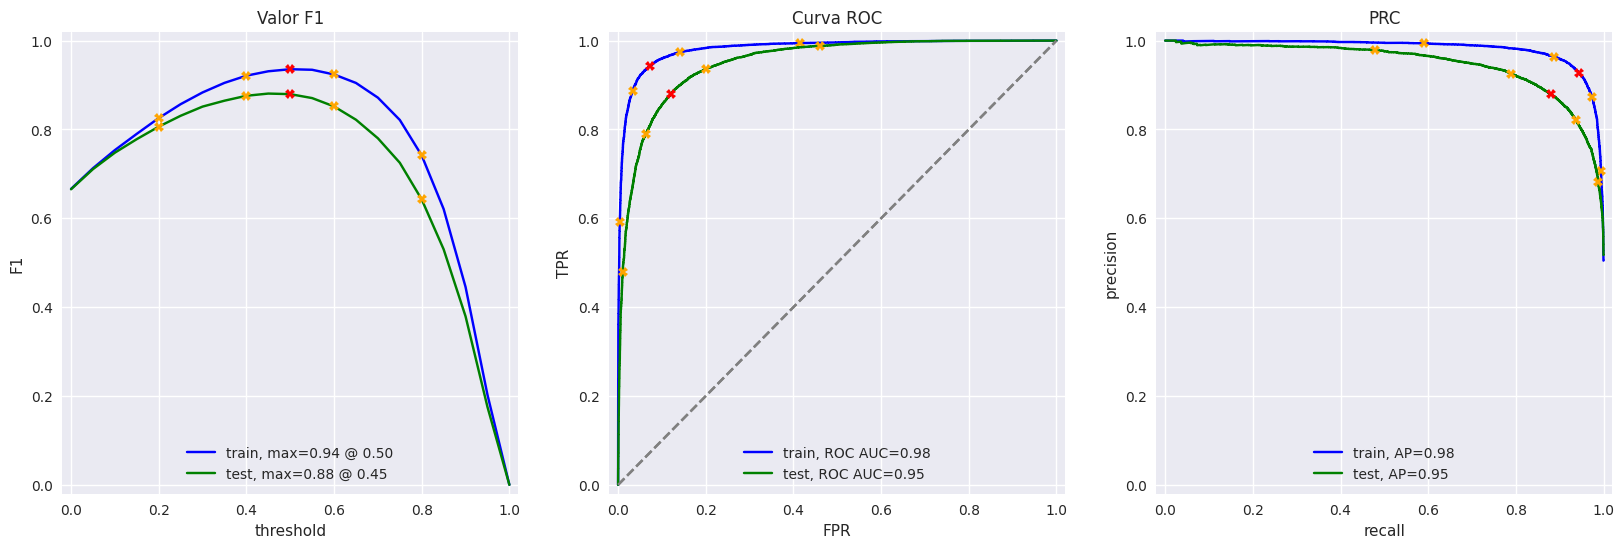

In [28]:
acc_m2, f1_m2, aps_m2, roc_m2=evaluate_model(model_2, train_features_tf_idf_2, train_target, test_features_tf_idf_2, test_target)

<font color=blue> En este modelo tenemos accurancy de .88 y un valor F1 de .88 para los datos de prueba, lo cual cumple con el minimo requerido para F1. </font>

### Modelo 3 - spaCy, TF-IDF y LR

In [29]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [30]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [31]:
train_features_pre_3 = df_reviews_train['review_norm'].apply(text_preprocessing_3)
test_features_pre_3 = df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [32]:
train_features_tf_idf_3, test_features_tf_idf_3, tfidf_vectorizer_3 = v_tfidf(train_features_pre_3,test_features_pre_3)

In [33]:
model_3=lr_model(train_features_tf_idf_3,train_target)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


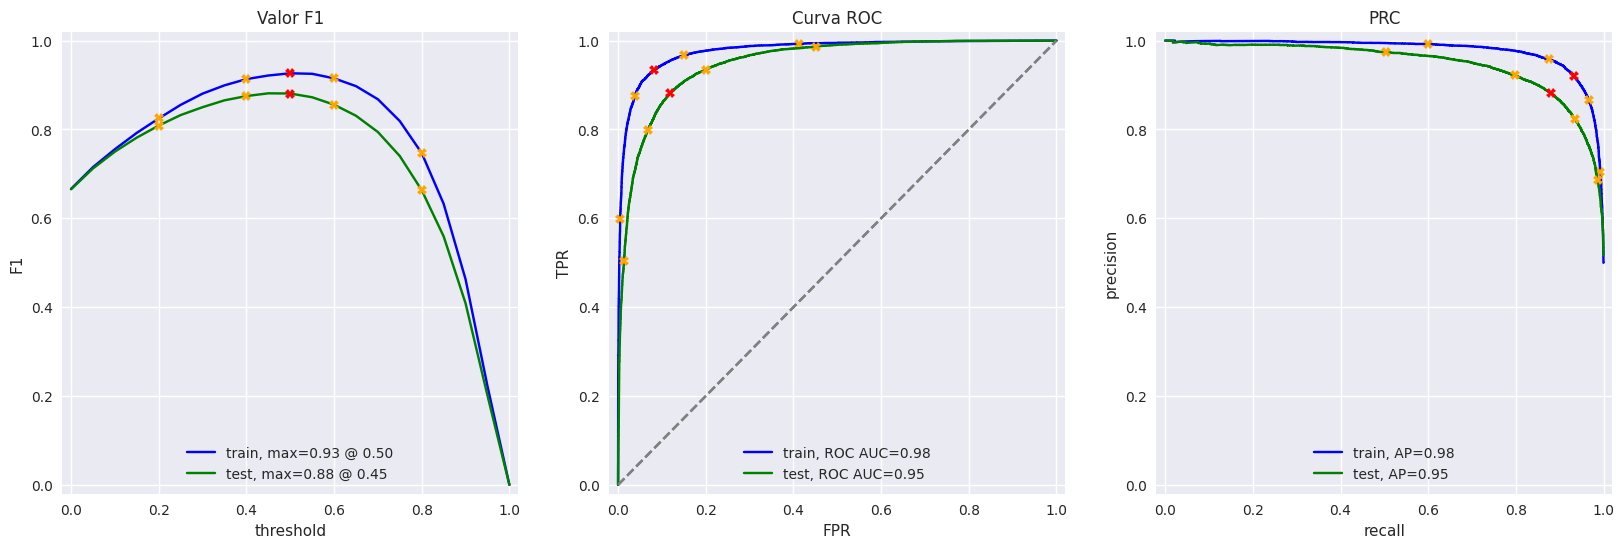

In [34]:
acc_m3, f1_m3, aps_m3, roc_m3=evaluate_model(model_3,train_features_tf_idf_3, train_target, test_features_tf_idf_3,test_target)

<FONT COLOR=BLUE> Asi como en el modelo anterior obtenemos un accurancy de .88 y F1 de .88 para el conjunto de prueba, igualmente cumple con el minimo requerido F1 mayor a .85 </FONT>

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [35]:
model_4=LGBMClassifier()

In [36]:
model_4.fit(train_features_tf_idf_3, train_target)


LGBMClassifier()

          train  test
Accuracy   0.92  0.86
F1         0.92  0.86
APS        0.98  0.94
ROC AUC    0.98  0.94


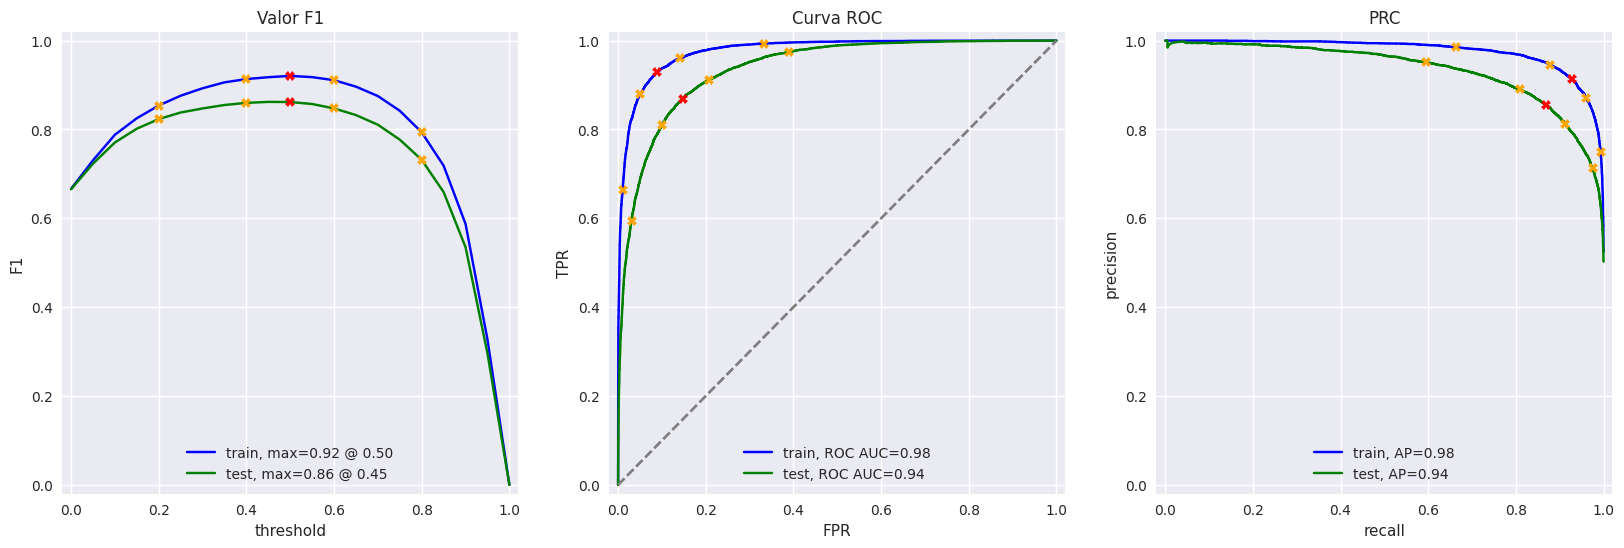

In [37]:
acc_m4, f1_m4, aps_m4, roc_m4=evaluate_model(model_4, train_features_tf_idf_3, train_target, test_features_tf_idf_3, test_target)


<font color=blue> En este caso, el modelo 4 con spacy tiene un accurancy de .86 y f1 de .86 es menor a los modelos anteriores sin embargo llega a cumplir con el F1 requerido </font> 

###  Modelo 9 - BERT

In [38]:
import tensorflow

In [39]:
import torch
import transformers


In [40]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False): # se baja a 25 para reducir los gastos de memoria 
    
    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención 
    # <escribe tu código aquí para crear ids_list y attention_mask_list>
    for txt in texts:
        ids = tokenizer.encode(txt.lower(), add_special_tokens=True,max_length=max_length, truncation=True)
        padded=np.array(ids + [0] * (max_length-len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(np.array(ids_list[batch_size*i:batch_size*(i+1)])).to(device)
        # <escribe tu código aquí para crear attention_mask_batch
        attention_mask_batch=torch.LongTensor(np.array(attention_mask_list[batch_size*i:batch_size*(i+1)])).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())#
        
    return np.concatenate(embeddings)

In [42]:
import os
if os.path.exists('features_9.npz'):
    print("embeddings cargados")
    
    with np.load('features_9.npz') as data:
        train_features_9 = data['train_features_9']
        test_features_9 = data['test_features_9']    
    
else:
    print("embeddings")
    #¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
    train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cpu')
    test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cpu')
    
    #Guardamos los embeddings
    np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

embeddings cargados


In [43]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'],force_device='cuda')

In [44]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

In [45]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(23796, 768)
(23796,)


In [46]:
model_9 = LogisticRegression(solver='lbfgs', max_iter=5000)

In [47]:
model_9.fit(train_features_9,df_reviews_train['pos'])

LogisticRegression(max_iter=5000)

          train  test
Accuracy   0.88  0.86
F1         0.88  0.86
APS        0.95  0.94
ROC AUC    0.95  0.94


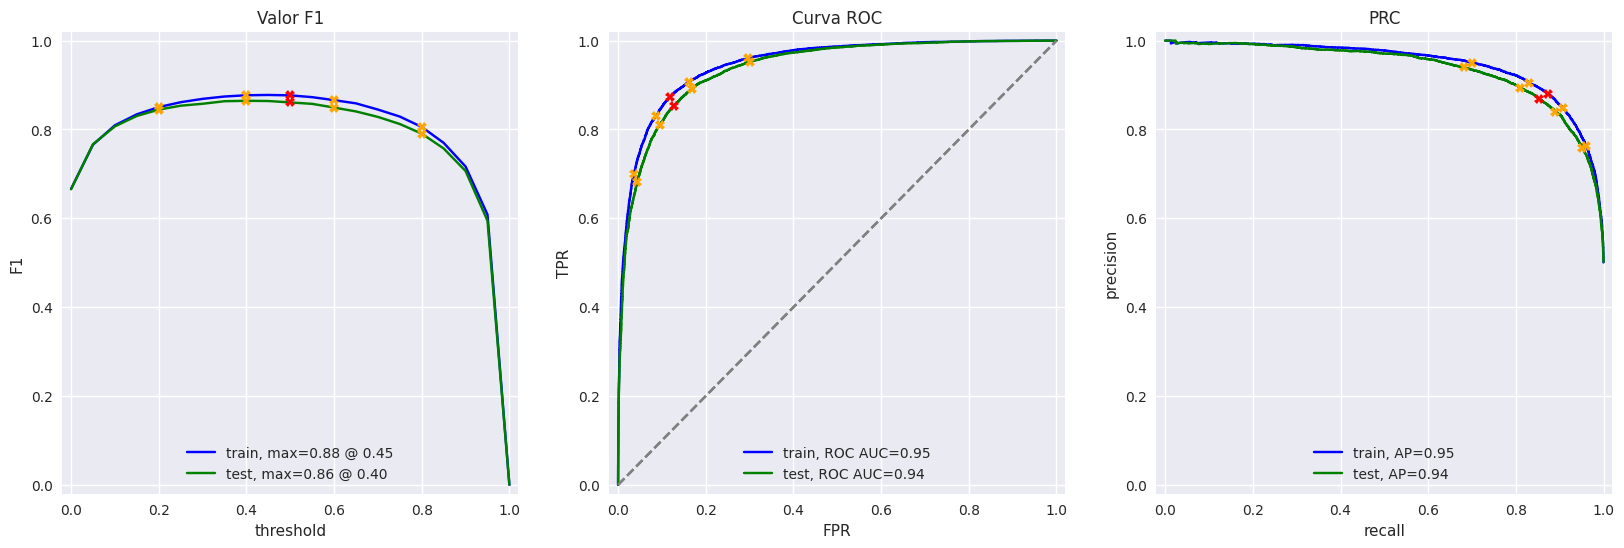

In [48]:
acc_m9, f1_m9, aps_m9, roc_m9=evaluate_model(model_9, train_features_9, df_reviews_train['pos'],test_features_9, df_reviews_test['pos'])


<font color=blue>El modelo 9 Bert es muy bueno sin embargo es el que mas puede llegar a tardar , en cuanto a los resultados se obtiene un accurancy del .86 y f1 de .86, pudiendose comparar con el modelo 4 , pero aun así es bajo a comparacion de los modelos 2 y 3, pero mas confiable por que no hay un sobreauste muy pronunciado. </font>

## Mis reseñas

In [50]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)# <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Modelo 2

In [51]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.36:  i did not simply like it not my kind of movie
0.31:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.27:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.39:  i didn't expect the reboot to be so good writers really cared about the source material
0.48:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.17:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.78:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 3

In [52]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.20:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.14:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.19:  i didn't expect the reboot to be so good writers really cared about the source material
0.68:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.87:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 4

In [53]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.56:  i did not simply like it not my kind of movie
0.43:  well i was bored and felt asleep in the middle of the movie
0.60:  i was really fascinated with the movie
0.57:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.47:  i didn't expect the reboot to be so good writers really cared about the source material
0.81:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.22:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.80:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 9

In [54]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.22:  i did not simply like it not my kind of movie
0.01:  well i was bored and felt asleep in the middle of the movie
0.98:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.15:  i didn't expect the reboot to be so good writers really cared about the source material
0.97:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.06:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.96:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Conclusiones

In [51]:
modelos_total = {
    'Modelo': ['Modelo Dummy-Constante (1)', 'Modelo NLTK,TF-IDF,LR (2)', 'Modelo spaCy,TF-IDF,LR (3)','Modelo LGBM (4)','Modelo BERT (9)'],    
    'Accurancy':[acc_m1,acc_m2,acc_m3,acc_m4,acc_m9],
    'F1':[f1_m1,f1_m2,f1_m3,f1_m4,f1_m9],
    'APS':[aps_m1,aps_m2,aps_m3,aps_m4,aps_m9],
    'ROC-AUC':[roc_m1,roc_m2,roc_m3,roc_m4,roc_m9]
}
modelos_total = pd.DataFrame(modelos_total)
print(modelos_total)



                       Modelo  Accurancy    F1   APS  ROC-AUC
0  Modelo Dummy-Constante (1)       0.50  0.49  0.50     0.50
1   Modelo NLTK,TF-IDF,LR (2)       0.88  0.88  0.95     0.95
2  Modelo spaCy,TF-IDF,LR (3)       0.88  0.88  0.95     0.95
3             Modelo LGBM (4)       0.86  0.86  0.94     0.94
4             Modelo BERT (9)       0.86  0.86  0.94     0.94


Al inicio podría parecer que el mejor modelo pudiera ser BERT (9), pero en sus reseñas se polariza demasiado tanto lo positivo como lo negativo, llegando casi al extremo, por ejemplo para la reseña 7 ("launching on netflix was a brave move i really appreciate ") se da una calificacion de .96 y en la reseña 3 (" even the actors looked really old and disinterested") se le da una calificacion de 0.00, dado que las calificaciones estan bastante polarizadas no es buena señal para el modelo en la tarea en especifico, ademas del tiempo de trabajo y recursos a gastar.
Los modelos 4 y 2 hacen bien la tarea pero dan calificaciones mas bajas a las reviews. 
Sin embargo el modelo 3 parece clasificar de manera mas efectiva y además cuenta con valores de accurancy, F1, average precision score y ROC AUC mejores.  


# Lista de comprobación

- [x]  Abriste el notebook
- [x]  Cargaste y preprocesaste los datos de texto para su vectorización
- [x]  Transformaste los datos de texto en vectores
- [x]  Entrenaste y probaste los modelos
- [x]  Se alcanzó el umbral de la métrica
- [x]  Colocaste todas las celdas de código en el orden de su ejecución
- [x]  Puedes ejecutar sin errores todas las celdas de código 
- [x]  Hay conclusiones 